# Evaluating Debiasing Methods Using Simulated Treatments from Cindy's Framework

To further assess the real-world utility of our debiasing framework, we adapt an experimental setup inspired by Cindy’s causal inference framework, which provides synthetic treatments and known confounders constructed from DHS survey data.

We begin by applying Cindy's scripts to our DHS locations to generate confounders and treatment assignments for each cluster. These variables are designed to mimic plausible causal structures in socioeconomic settings, making them suitable for validating treatment effect estimation methods.

Next, we randomly divide the dataset into two disjoint sets: **upstream** and **downstream** locations. We train our predictive model using the upstream subset, where the true IWI values are known, and use it to predict IWI in the downstream subset. Importantly, we restrict the causal analysis to the downstream locations, ensuring that the outcome model has not been trained on them.

We then estimate treatment effects in the downstream group using several outcome types:

* **True IWI values** from the DHS survey
* **Model-predicted IWI values (naïve)** using MSE-trained outputs
* **Debiased predictions**, using both Tweedie correction and Linear Calibration Correction (LCC)

Comparing the estimated treatment effects from the debiased models to those obtained using the true outcomes allows us to assess the practical validity of our correction methods. If the debiased predictions recover treatment effects that closely match the ground truth analysis, this provides strong empirical support for the use of our method in observational ML pipelines where only predicted outcomes are available.

**TODO**:

- Remove image based confounders
- Reintroduce more survey points. Seems like Cindy only used points from the country-year combo closest to 2000. 


In [1]:
import os
import pandas as pd
import re
import numpy as np
import itertools
import configparser
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

sns.set_theme()

# Read config file
config = configparser.ConfigParser()
config.read('../config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

exp_dir = os.path.join(DATA_DIR, 'cindy_experiments')

In [ ]:
pd.read_csv('/mimer/NOBACKUP/groups/globalpoverty1/cindy/eoml_ch_wb/data/interim/dhs_est_iwi.csv').groupby('country').size()

country
angola                           62
benin                           190
burkina_faso                     81
burundi                         307
cameroon                        464
central_african_republic         66
chad                            235
comoros                         242
democratic_republic_of_congo    291
egypt                             7
eswatini                        210
ethiopia                        506
gabon                           332
ghana                           144
guinea                          290
ivory_coast                      63
kenya                           389
lesotho                         344
liberia                          30
madagascar                      260
malawi                          555
mali                            167
morocco                         344
mozambique                      609
namibia                         260
niger                           184
nigeria                         356
rwanda              

In [2]:
#uncomment to test
# fund_sect_param <- "wb_110"
# fund_sect_param <- "ch_430"
# run <- "cnn_5k_annual"
# iterations <- 15
# time_approach <- "annual"   #other option: "3yr"
# vision_backbone <- "cnn"     #other options: "emb" and "vt"

## Initial setup, parameter processing, reading input files

In [3]:
fund_sect_param = "wb_110"

sector_param = re.sub(r".*_(\d+).*", r"\1", fund_sect_param)
funder_param = re.sub(r"(wb|ch).*", r"\1", fund_sect_param)
other_funder = "ch" if funder_param == "wb" else "wb"

print('Sector', sector_param)
print('Funder', funder_param)
print('Other funder', other_funder)

Sector 110
Funder wb
Other funder ch


In [4]:
if os.path.isfile(os.path.join(exp_dir, f'{funder_param}_{sector_param}.csv')):
  print('Analysis already done')
  print(7/0)

In [5]:
df_path = os.path.join(exp_dir, 'dhs_5k_confounders.csv')

drop_columns = ['rural.y', 'year']
rename_columns = {'rural.x': 'rural'}
dhs_confounders_df = pd.read_csv(df_path)
dhs_confounders_df.drop(drop_columns, axis=1, inplace=True)
dhs_confounders_df.rename(rename_columns, axis=1, inplace=True)
dhs_confounders_df.head()

,country,survey_start_year,lat,lon,households,rural,iwi,dhs_id,iso3,iwi_1990_1992_est,...,log_ch_loan_proj_n_2002_2004,log_ch_loan_proj_n_2005_2007,log_ch_loan_proj_n_2008_2010,log_ch_loan_proj_n_2011_2013,log_ch_loan_proj_n_2014_2016,log_disasters1999_2001,log_disasters2002_2004,log_disasters2005_2007,log_disasters2008_2010,log_disasters2011_2013
0,south_africa,2016,-34.463232,19.542468,6,1,70.723295,48830,ZAF,35.205078,...,-4.60517,-4.60517,-4.60517,-4.60517,-4.60517,-4.60517,0.00995,0.00995,-4.60517,0.00995
1,south_africa,2016,-34.418873,19.188926,11,0,76.798705,48781,ZAF,49.243164,...,-4.60517,-4.60517,-4.60517,-4.60517,-4.60517,-4.60517,0.00995,0.00995,-4.60517,0.00995
2,south_africa,2016,-34.412835,19.178965,4,0,81.053723,48828,ZAF,48.388672,...,-4.60517,-4.60517,-4.60517,-4.60517,-4.60517,-4.60517,0.00995,0.00995,-4.60517,0.00995
3,south_africa,2016,-34.292107,19.563813,6,1,72.766880,48787,ZAF,21.789551,...,-4.60517,-4.60517,-4.60517,-4.60517,-4.60517,-4.60517,0.00995,0.00995,-4.60517,0.00995
4,south_africa,2016,-34.187500,22.113079,3,0,77.864113,48756,ZAF,44.042970,...,-4.60517,-4.60517,-4.60517,-4.60517,-4.60517,-4.60517,0.00995,0.00995,-4.60517,0.00995


Get list of all dhs_id's and their iso3 for use below

In [6]:
# Get a DataFrame with distinct dhs_id and iso3
dhs_iso3_df = dhs_confounders_df[['dhs_id', 'iso3']].drop_duplicates()

Get treated by this funder, which already has treated_other_funder column populated

In [7]:
dhs_t_s_df = pd.read_csv(os.path.join(exp_dir, 'dhs_treated_sector_annual.csv'))

# Filter rows based on sector, funder, and start_year
dhs_t_s_df_filtered = dhs_t_s_df[
    (dhs_t_s_df['sector'] == int(sector_param)) &
    (dhs_t_s_df['funder'] == funder_param) &
    (dhs_t_s_df['start_year'] >= 2002)
]

# Select relevant columns from dhs_confounders_df and merge with the filtered DataFrame
dhs_t_df = dhs_t_s_df_filtered.merge(
    dhs_confounders_df[['dhs_id', 'ID_adm2']],
    on='dhs_id',
    how='inner'
)

Get logged count of projects in other sectors for each dhs point and year

In [8]:
# Filter the data based on the specified conditions
dhs_filtered = dhs_t_s_df[
    (dhs_t_s_df['sector'] != int(sector_param)) &
    (dhs_t_s_df['funder'] == funder_param) &
    (dhs_t_s_df['start_year'] >= 2002) &
    (dhs_t_s_df['dhs_id'].isin(dhs_confounders_df['dhs_id']))
]

# Group by dhs_id and start_year, then calculate the sum of proj_count
dhs_grouped = dhs_filtered.groupby(['dhs_id', 'start_year'], as_index=False).agg(
    other_sect_n=('proj_count', 'sum')
)

# Add a new column for the logged count of projects in other sectors
dhs_grouped['log_other_sect_n'] = np.log(dhs_grouped['other_sect_n'] + 1)

# Drop the other_sect_n column and get the final DataFrame
dhs_other_sect_n_df = dhs_grouped.drop(columns=['other_sect_n'])

Get logged count of the other funder's simultaneous projects

In [9]:
# Filter the data based on the specified conditions
dhs_filtered_other_funder = dhs_t_s_df[
    (dhs_t_s_df['funder'] == other_funder) &
    (dhs_t_s_df['dhs_id'].isin(dhs_confounders_df['dhs_id']))
]

# Group by dhs_id and start_year, then calculate the sum of proj_count
dhs_grouped_other_funder = dhs_filtered_other_funder.groupby(['dhs_id', 'start_year'], as_index=False).agg(
    treated_other_funder_n=('proj_count', 'sum')
)

# Add a new column for the logged count of the other funder's simultaneous projects
dhs_grouped_other_funder['log_treated_other_funder_n'] = np.log(dhs_grouped_other_funder['treated_other_funder_n'] + 1)

# Drop the treated_other_funder_n column and get the final DataFrame
dhs_treated_other_funder_n_df = dhs_grouped_other_funder.drop(columns=['treated_other_funder_n'])

Identify countries where the funder is operating in this sector

In [10]:
funder_sector_iso3 = dhs_confounders_df[
    dhs_confounders_df['dhs_id'].isin(dhs_t_df['dhs_id'])
]['iso3'].drop_duplicates().tolist()

Identify all dhs_points in countries where the funder is operating in this sector

In [11]:
dhs_in_operating_countries = dhs_iso3_df[
    dhs_iso3_df['iso3'].isin(funder_sector_iso3)
]['dhs_id'].tolist()

Construct annual controls, limiting to countries where funder operated in sector. Generate dataframe of all dhs points for all years in operating countries

In [12]:
# Define the range of years and create a DataFrame of all dhs points for all years in operating countries
years = list(range(2002, 2015))
all_combinations = list(itertools.product(years, dhs_in_operating_countries))

# Convert the combinations into a DataFrame
all_t_c_df = pd.DataFrame(all_combinations, columns=['start_year', 'dhs_id'])

Get treated by other funder to set treated_other_funder on control points

In [13]:
# Filter the data based on the specified conditions
dhs_t_other_df = dhs_t_s_df[
    (dhs_t_s_df['sector'] == int(sector_param)) &
    (dhs_t_s_df['funder'] == other_funder) &
    (dhs_t_s_df['dhs_id'].isin(dhs_confounders_df['dhs_id']))
]

# Add a new column 'treated_other_funder' and set its value to 1
dhs_t_other_df['treated_other_funder'] = 1

/local/tmp.4397004/ipykernel_2392321/4011286338.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dhs_t_other_df['treated_other_funder'] = 1


Construct controls

In [14]:
# Exclude dhs_points treated in each year
dhs_c_df = all_t_c_df.merge(
    dhs_t_df[['dhs_id', 'start_year']],
    on=['dhs_id', 'start_year'],
    how='left',
    indicator=True
).query('_merge == "left_only"').drop(columns='_merge')

# Exclude DHS points where confounder data not available, get ID_adm2
dhs_c_df = dhs_c_df.merge(
    dhs_confounders_df[['dhs_id', 'ID_adm2']],
    on='dhs_id',
    how='inner'
)

Get neighbor project counts for spillover effects

In [15]:
adm2_adjacent_annual_treat_count_df = pd.read_csv(os.path.join(exp_dir, 'adm2_adjacent_annual_treat_count.csv'))

Define the variable order and labels for boxplots and dropped columns variables

In [16]:
var_order_all = [
    "iwi_est_post_oda", "log_pc_nl_pre_oda", "log_avg_pop_dens",
    "log_avg_min_to_city", "log_dist_km_to_gold", "log_dist_km_to_gems",
    "log_dist_km_to_dia", "log_dist_km_to_petro",
    "leader_birthplace", "log_ch_loan_proj_n",
    "log_3yr_pre_conflict_deaths", "log_disasters",
    "election_year", "unsc_aligned_us", "unsc_non_aligned_us", "country_gini",
    "corruption_control", "gov_effectiveness", "political_stability",
    "reg_quality", "rule_of_law", "voice_accountability",
    "log_treated_other_funder_n", "log_other_sect_n",
    "log_total_neighbor_projs"
]

var_labels_all = [
    "Wealth (est, t+1)", "Nightlights per cap (t-1,log)", "Pop Density (t-1,log)",
    "Minutes to City (2000,log)", "Dist to Gold (km,log)",
    "Dist to Gems (km,log)", "Dist to Diam (km,log)",
    "Dist to Oil (km,log)", "Leader birthplace (t-1)", "Concurrent Loan Projs",
    "Conflict deaths (t-1,log)", "Natural Disasters (t-1,log)",
    "Election year (t-1)", "UNSC US aligned (t-1)", "UNSC Non-US aligned (t-1)",
    "Country gini (t-1)",
    "Cntry Cntrl Corruption (t-1)", "Cntry Gov Effective (t-1)",
    "Cntry Political Stability (t-1)", "Cntry Reg Quality (t-1)",
    "Cntry Rule of Law (t-1)", "Ctry Voice/Account (t-1)",
    "Landsat 5,7,& 8", "Other Funder Treat n (log)", "Other Sector Proj n (log)",
    "Adj ADM2 Proj n (log)"
]


In [17]:
treat_count = len(dhs_t_df)
control_count = len(dhs_c_df)

treat_count, control_count

(5175, 91129)

## Combine treated & controls into same dataframe, join with confounders, and adjust to be appropriate for start year

In [18]:
# Combine treated and controls into the same DataFrame
dhs_t_df['treated'] = 1
dhs_c_df['treated'] = 0

# Concatenate treated and control DataFrames
obs_year_df = pd.concat([dhs_t_df[['dhs_id', 'start_year', 'treated']],
                         dhs_c_df[['dhs_id', 'start_year', 'treated']]])

In [19]:
# Join with confounders
obs_year_df = obs_year_df.merge(
    dhs_confounders_df,
    on='dhs_id',
    how='left'
)

In [20]:
# Get count of projects in neighboring adm2s for the period
obs_year_df = obs_year_df.merge(
    adm2_adjacent_annual_treat_count_df,
    left_on=['ID_adm2', 'start_year'],
    right_on=['ID_adm2', 'start_year'],
    how='left'
)

In [21]:
# Replace NaNs with 0 for dhs points without neighboring projects
obs_year_df['total_neighbor_projs'] = obs_year_df['total_neighbor_projs'].fillna(1)
obs_year_df['log_total_neighbor_projs'] = obs_year_df['log_total_neighbor_projs'].fillna(0)

In [22]:
# Get logged count of funder's projects in other sectors for both treated and controls
obs_year_df = obs_year_df.merge(
    dhs_other_sect_n_df,
    on=['dhs_id', 'start_year'],
    how='left'
)

# Replace NaNs with 0 for dhs points untreated in other sectors
obs_year_df['log_other_sect_n'] = obs_year_df['log_other_sect_n'].fillna(0)

In [23]:
# Get logged count of other funder's projects for both treated and controls
obs_year_df = obs_year_df.merge(
    dhs_treated_other_funder_n_df,
    on=['dhs_id', 'start_year'],
    how='left'
)

# Replace NaNs with 0 for dhs points untreated by the other funder
obs_year_df['log_treated_other_funder_n'] = obs_year_df['log_treated_other_funder_n'].fillna(0)

In [24]:
obs_year_df

,dhs_id,start_year,treated,country,survey_start_year,lat,lon,households,rural,iwi,...,log_ch_loan_proj_n_2014_2016,log_disasters1999_2001,log_disasters2002_2004,log_disasters2005_2007,log_disasters2008_2010,log_disasters2011_2013,total_neighbor_projs,log_total_neighbor_projs,log_other_sect_n,log_treated_other_funder_n
0,2933,2002,1,burkina_faso,1998,12.371574,-1.771793,13,0,33.177228,...,-4.60517,-4.60517,0.00995,0.009950,-4.60517,-4.60517,1.0,0.000000,2.079442,0.000000
1,2933,2008,1,burkina_faso,1998,12.371574,-1.771793,13,0,33.177228,...,-4.60517,-4.60517,0.00995,0.009950,-4.60517,-4.60517,4.0,1.609438,1.609438,0.000000
2,2933,2012,1,burkina_faso,1998,12.371574,-1.771793,13,0,33.177228,...,-4.60517,-4.60517,0.00995,0.009950,-4.60517,-4.60517,1.0,0.000000,0.000000,0.000000
3,2933,2013,1,burkina_faso,1998,12.371574,-1.771793,13,0,33.177228,...,-4.60517,-4.60517,0.00995,0.009950,-4.60517,-4.60517,4.0,1.609438,1.609438,0.000000
4,2933,2014,1,burkina_faso,1998,12.371574,-1.771793,13,0,33.177228,...,-4.60517,-4.60517,0.00995,0.009950,-4.60517,-4.60517,1.0,0.000000,1.791759,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96299,52279,2010,0,uganda,2000,0.378678,32.566661,18,0,35.461890,...,-4.60517,-4.60517,-4.60517,0.698135,-4.60517,0.00995,5.0,1.791759,0.000000,1.098612
96300,52279,2011,0,uganda,2000,0.378678,32.566661,18,0,35.461890,...,-4.60517,-4.60517,-4.60517,0.698135,-4.60517,0.00995,3.0,1.386294,0.693147,0.693147
96301,52279,2012,0,uganda,2000,0.378678,32.566661,18,0,35.461890,...,-4.60517,-4.60517,-4.60517,0.698135,-4.60517,0.00995,1.0,0.000000,0.000000,0.000000
96302,52279,2013,0,uganda,2000,0.378678,32.566661,18,0,35.461890,...,-4.60517,-4.60517,-4.60517,0.698135,-4.60517,0.00995,3.0,1.386294,1.386294,1.098612


This is the part to replace with our maps

In [25]:
# Set iwi_est_post_oda based on start year
obs_year_df['iwi_est_post_oda'] = np.select(
    [
        obs_year_df['start_year'].between(2000, 2001),
        obs_year_df['start_year'].between(2002, 2004),
        obs_year_df['start_year'].between(2005, 2007),
        obs_year_df['start_year'].between(2008, 2010),
        obs_year_df['start_year'].between(2011, 2013),
        obs_year_df['start_year'] == 2014
    ],
    [
        obs_year_df['iwi_2002_2004_est'],
        obs_year_df['iwi_2005_2007_est'],
        obs_year_df['iwi_2008_2010_est'],
        obs_year_df['iwi_2011_2013_est'],
        obs_year_df['iwi_2014_2016_est'],
        obs_year_df['iwi_2017_2019_est']
    ]
)

In [26]:
# Set log_dist_km_to_gold based on start year
obs_year_df['log_dist_km_to_gold'] = np.where(
    obs_year_df['start_year'].between(2000, 2001),
    obs_year_df['log_dist_km_to_gold_pre2001'],
    obs_year_df['log_dist_km_to_gold_2001']
)

In [27]:
# Set log_dist_km_to_petro based on start year
obs_year_df['log_dist_km_to_petro'] = np.where(
    obs_year_df['start_year'] == 1999,
    obs_year_df['log_dist_km_to_petro_1999'],
    np.where(
        obs_year_df['start_year'].between(2000, 2002),
        obs_year_df['log_dist_km_to_petro_2000_2002'],
        obs_year_df['log_dist_km_to_petro_2003']
    )
)

In [28]:
def get_prev_year_values(row):
    start_year = row['start_year']
    row['log_pc_nl_pre_oda'] = row[f'log_pc_nl_{start_year - 1}']
    row['log_avg_pop_dens'] = row[f'log_avg_pop_dens_{start_year - 1}']
    row['leader_birthplace'] = row[f'leader_{start_year - 1}']
    row['log_3yr_pre_conflict_deaths'] = row[f'log_deaths{start_year - 3}_{start_year - 1}']
    row['log_disasters'] = row[f'log_disasters{start_year - 1}']
    row['log_ch_loan_proj_n'] = row[f'log_ch_loan_proj_n_{start_year - 1}']

    return row

# Run "apply" in parallell to speed up
obs_year_df = obs_year_df.progress_apply(get_prev_year_values, axis=1)

100%|██████████| 96304/96304 [02:49<00:00, 567.12it/s]


In [29]:
# Drop rows with NaN values
obs_year_df = obs_year_df.dropna()

Join to country-level parameters, which are year specific

In [31]:
# Read the country-level parameters CSV
country_confounders_df = pd.read_csv(os.path.join(exp_dir, "country_confounders.csv"))

# Remove the 'country' column
country_confounders_df = country_confounders_df.drop(columns=['country'])

# Add 1 to the 'year' column to align with the join in the next step
country_confounders_df['year'] = country_confounders_df['year'] + 1

# Join with obs_year_df on iso3 and year (adjusted to be 1 year pre-project)
run_df = obs_year_df.merge(
    country_confounders_df,
    left_on=['iso3', 'start_year'],
    right_on=['iso3', 'year'],
    how='left'
)

# Drop the 'year' column from run_df as it's no longer needed
run_df = run_df.drop(columns=['year'])

In [33]:
use_columns = ['dhs_id', 'country', 'iso3', 'ID_adm2','lat', 'lon', 'treated', 'log_treated_other_funder_n',
           'log_other_sect_n', 'start_year', 'image_file_annual', 'iwi_est_post_oda',
           'log_pc_nl_pre_oda', 'log_avg_min_to_city', 'log_avg_pop_dens',
           'log_3yr_pre_conflict_deaths', 'log_disasters', 'log_ch_loan_proj_n',
           'leader_birthplace', 'log_dist_km_to_gold',
           'log_dist_km_to_gems', 'log_dist_km_to_dia', 'log_dist_km_to_petro',
           'election_year', 'unsc_aligned_us', 'unsc_non_aligned_us',
           'country_gini', 'corruption_control',
           'gov_effectiveness', 'political_stability', 'reg_quality', 'rule_of_law',
           'voice_accountability','log_total_neighbor_projs']

#img_feat_columns = [str(i) for i in range(768)]
#use_columns += img_feat_columns

pre_shuffle_df = run_df[use_columns].rename(columns={'ID_adm2': 'adm2'})

Shuffle data to reorder it before use

In [34]:
input_df = pre_shuffle_df.sample(frac=1, random_state=42)

Save as csv for reuse.

In [35]:
input_df.to_csv(os.path.join(exp_dir, f'{funder_param}_{sector_param}.csv'), index=False)

In [37]:
input_df.columns

Index(['dhs_id', 'country', 'iso3', 'adm2', 'lat', 'lon', 'treated',
       'log_treated_other_funder_n', 'log_other_sect_n', 'start_year',
       'image_file_annual', 'iwi_est_post_oda', 'log_pc_nl_pre_oda',
       'log_avg_min_to_city', 'log_avg_pop_dens',
       'log_3yr_pre_conflict_deaths', 'log_disasters', 'log_ch_loan_proj_n',
       'leader_birthplace', 'log_dist_km_to_gold', 'log_dist_km_to_gems',
       'log_dist_km_to_dia', 'log_dist_km_to_petro', 'election_year',
       'unsc_aligned_us', 'unsc_non_aligned_us', 'country_gini',
       'corruption_control', 'gov_effectiveness', 'political_stability',
       'reg_quality', 'rule_of_law', 'voice_accountability',
       'log_total_neighbor_projs'],
      dtype='object')

## Run analysis

Check if there are any nan values in input data before proceeding

In [38]:
# Check for incomplete cases
if input_df.isna().any().any():
    raise ValueError('Nan values in \"input_df\"')

Construct the confounding matrix

In [40]:
before_cols = [
    'start_year',
    'log_pc_nl_pre_oda',
    'log_avg_min_to_city',
    'log_avg_pop_dens',
    'log_dist_km_to_gold',
    'log_dist_km_to_gems',
    'log_dist_km_to_dia',
    'log_dist_km_to_petro',
    'log_treated_other_funder_n',
    'log_ch_loan_proj_n',
    'log_other_sect_n',
    'log_3yr_pre_conflict_deaths',
    'log_disasters',
    'leader_birthplace',
    'election_year',
    'unsc_aligned_us',
    'unsc_non_aligned_us',
    'country_gini',
    'corruption_control',
    'gov_effectiveness',
    'political_stability',
    'reg_quality',
    'rule_of_law',
    'voice_accountability',
    'log_total_neighbor_projs'
]# + img_feat_columns

conf_df = input_df[before_cols]

# Create the model matrix for adm2 fixed effects
adm2_fixed_effects = pd.get_dummies(input_df['adm2'], drop_first=False).astype(int)

# Combine confounding matrix with adm2 fixed effects
conf_df = pd.concat([conf_df, adm2_fixed_effects], axis=1)
conf_matrix = conf_df.values

Remove any columns that have 0 standard deviation before passing to function

In [41]:
# Save the column names before filtering
before_cols = conf_df.columns

# Remove columns with zero standard deviation
conf_df = conf_df.loc[:, conf_df.apply(np.std) > 0]

# Identify dropped columns
dropped_cols = set(before_cols) - set(conf_df.columns)
dropped_labels = "; ".join([var_labels_all[var_order_all.index(col)] for col in dropped_cols])

# Print dropped columns if any
if dropped_labels:
    print(f"Dropped for 0 SD: {dropped_labels}")

Remove no-variation columns from the variables that control later figures

In [42]:
var_order = [var for var in var_order_all if var not in dropped_cols]

var_labels = [
    label for label in var_labels_all
    if label not in [var_labels_all[var_order_all.index(col)] for col in dropped_cols]
]

In [43]:
conf_df

,start_year,log_pc_nl_pre_oda,log_avg_min_to_city,log_avg_pop_dens,log_dist_km_to_gold,log_dist_km_to_gems,log_dist_km_to_dia,log_dist_km_to_petro,log_treated_other_funder_n,log_ch_loan_proj_n,...,c97r6r25,c97r7r26,c97r7r27,c97r7r28,c97r8r29,c97r8r30,c97r8r31,c97r8r32,c97r8r33,c97r8r34
27291,2008,0.004184,6.673893,6.263297,6.377616,6.082577,6.514100,5.685041,0.693147,-4.60517,...,0,0,0,0,0,0,0,0,0,0
52220,2013,0.000000,6.357496,4.216524,5.652956,5.894128,7.489970,5.541043,0.000000,-4.60517,...,0,0,0,0,0,0,0,0,0,0
127,2006,0.003323,1.871802,9.971391,5.520233,6.255945,7.368238,6.360030,0.693147,-4.60517,...,0,0,0,0,0,0,0,0,0,0
26970,2009,0.000000,5.423039,4.191671,6.023635,3.154495,5.942385,6.490217,0.000000,-4.60517,...,0,0,0,0,0,0,0,0,0,0
41639,2014,0.000000,5.889524,4.868422,4.879665,5.769931,6.614306,6.979081,0.000000,-4.60517,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,2013,0.002989,5.226105,4.325098,5.270448,6.181910,4.185556,6.395243,0.000000,-4.60517,...,0,0,0,0,0,0,0,0,0,0
54886,2010,0.000000,5.075590,3.659699,5.577981,4.926892,6.331542,4.561914,0.000000,-4.60517,...,0,0,0,0,0,0,0,0,0,0
76820,2010,0.000000,5.707000,4.500320,5.345846,6.240153,4.621471,6.225171,0.000000,-4.60517,...,0,0,0,0,0,0,0,0,0,0
860,2006,0.014498,3.120895,8.472976,4.917531,5.688810,4.250684,5.786169,0.693147,-4.60517,...,0,0,0,0,0,0,0,0,0,0


## Estimate ATE

In [44]:
from sklearn.linear_model import LogisticRegression

# Extract the confounders and treatment indicator
X = conf_df.values
X = (X - X.mean(axis=0)) / X.std(axis=0)
treatment = input_df['treated']

# Fit logistic regression model
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X, treatment)

# Predict propensity scores
propensity_scores = log_reg.predict_proba(X)[:, 1]

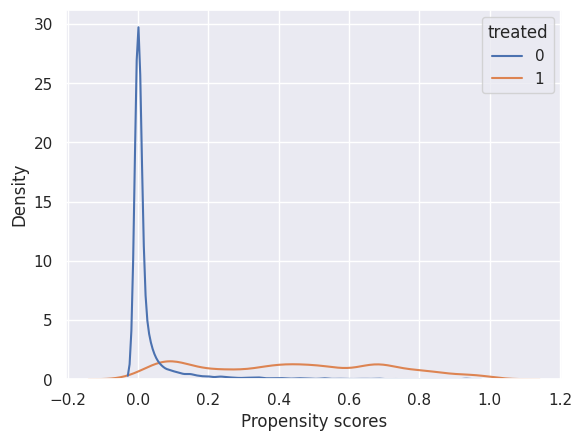

In [45]:
sns.kdeplot(x=propensity_scores, hue=treatment, common_norm=False)
plt.xlabel('Propensity scores')
plt.show()

In [ ]:
def calculate_ate_iptw(labels, treatment_status, propensity_score):
    """
    Calculate Average Treatment Effect (ATE) using IPTW.

    Parameters:
    - labels: numpy array of observed outcomes (Y)
    - treatment_status: numpy array of treatment assignment (T, binary: 1/0)
    - propensity_score: numpy array of propensity scores (e)

    Returns:
    - ATE (float)
    """

    # Avoid division by zero by clipping the propensity scores
    epsilon = 1e-6
    propensity_score = np.clip(propensity_score, epsilon, 1 - epsilon)

    # Calculate weights
    treated_weights = treatment_status / propensity_score
    control_weights = (1 - treatment_status) / (1 - propensity_score)

    # Compute the weighted outcomes
    treated_outcomes = treated_weights * labels
    control_outcomes = control_weights * labels

    # Estimate ATE
    ate = np.mean(treated_outcomes - control_outcomes)

    return ate

calculate_ate_iptw(input_df['iwi_est_post_oda'].values, treatment, propensity_scores)

-14.108324346228535

In [46]:
iptw = treatment / propensity_scores + (1 - treatment) / (1 - propensity_scores)

In [ ]:
y = input_df['iwi_est_post_oda'].values

# Save y, treatment, and iptw to npy arrays
np.save(os.path.join(exp_dir, f'{funder_param}_{sector_param}_y.npy'), y)
np.save(os.path.join(exp_dir, f'{funder_param}_{sector_param}_treatment.npy'), treatment)
np.save(os.path.join(exp_dir, f'{funder_param}_{sector_param}_iptw.npy'), iptw)

# Read the saved arrays
y = np.load(os.path.join(exp_dir, f'{funder_param}_{sector_param}_y.npy'))
treatment = np.load(os.path.join(exp_dir, f'{funder_param}_{sector_param}_treatment.npy'))
iptw = np.load(os.path.join(exp_dir, f'{funder_param}_{sector_param}_iptw.npy'))

In [47]:
import statsmodels.api as sm

# Adding a constant term to the model for intercept
intercept = np.ones(treatment.shape)

# Post-treatment outcome model
model = sm.WLS(input_df['iwi_est_post_oda'].values, np.column_stack([intercept, treatment]), weights=iptw)
result = model.fit()

print(result.summary())

ModuleNotFoundError: No module named 'statsmodels'